
# Subtractive synthesis

**Author**: [Moto Hira](moto@meta.com)_

This tutorial is the continuation of
[Filter Design Tutorial](./filter_design_tutorial.html)_.

This tutorial shows how to perform subtractive synthesis with TorchAudio's DSP functions.

Subtractive synthesis creates timbre by applying filters to source waveform.

<div class="alert alert-danger"><h4>Warning</h4><p>This tutorial requires prototype DSP features, which are
   available in nightly builds.

   Please refer to https://pytorch.org/get-started/locally
   for instructions for installing a nightly build.</p></div>


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.3.0.dev20240222
2.2.0.dev20240222


## Overview





In [2]:
try:
    from torchaudio.prototype.functional import filter_waveform, frequency_impulse_response, sinc_impulse_response
except ModuleNotFoundError:
    print(
        "Failed to import prototype DSP features. "
        "Please install torchaudio nightly builds. "
        "Please refer to https://pytorch.org/get-started/locally "
        "for instructions to install a nightly build."
    )
    raise

import matplotlib.pyplot as plt
from IPython.display import Audio

## Filtered Noise

Subtractive synthesis starts with a waveform and applies filters to
some frequency components.

For the first example of subtractive synthesis, we apply
time-varying low pass filter to white noise.

First, we create a white noise.




In [3]:
SAMPLE_RATE = 16_000
duration = 4
num_frames = int(duration * SAMPLE_RATE)

noise = torch.rand((num_frames,)) - 0.5

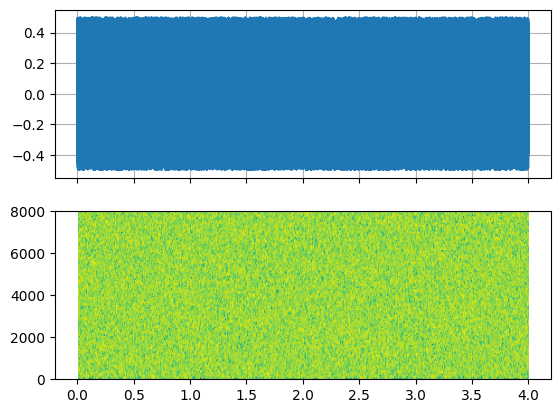

In [4]:
def plot_input():
    fig, axes = plt.subplots(2, 1, sharex=True)
    t = torch.linspace(0, duration, num_frames)
    axes[0].plot(t, noise)
    axes[0].grid(True)
    axes[1].specgram(noise, Fs=SAMPLE_RATE)
    Audio(noise, rate=SAMPLE_RATE)


plot_input()

## Windowed-sinc filter




### Sweeping cutoff frequency

We use :py:func:`~torchaudio.prototype.functional.sinc_impulse_response` to
create series of low pass filters, while changing the  cut-off
frequency from zero to Nyquist frequency.




In [5]:
num_filters = 64 * duration
window_size = 2049

f_cutoff = torch.linspace(0.0, 0.8, num_filters)
kernel = sinc_impulse_response(f_cutoff, window_size)

To apply time-varying filter, we use
:py:func:`~torchaudio.prototype.functional.filter_waveform`




In [6]:
filtered = filter_waveform(noise, kernel)

Let's look at the spectrogram of the resulting audio and listen to it.




In [7]:
def plot_sinc_ir(waveform, cutoff, sample_rate, vol=0.2):
    num_frames = waveform.size(0)
    duration = num_frames / sample_rate
    num_cutoff = cutoff.size(0)
    nyquist = sample_rate / 2

    _, axes = plt.subplots(2, 1, sharex=True)
    t = torch.linspace(0, duration, num_frames)
    axes[0].plot(t, waveform)
    axes[0].grid(True)
    axes[1].specgram(waveform, Fs=sample_rate, scale="dB")
    t = torch.linspace(0, duration, num_cutoff)
    axes[1].plot(t, cutoff * nyquist, color="gray", linewidth=0.8, label="Cutoff Frequency", linestyle="--")
    axes[1].legend(loc="upper center")
    axes[1].set_ylim([0, nyquist])
    waveform /= waveform.abs().max()
    return Audio(vol * waveform, rate=sample_rate, normalize=False)

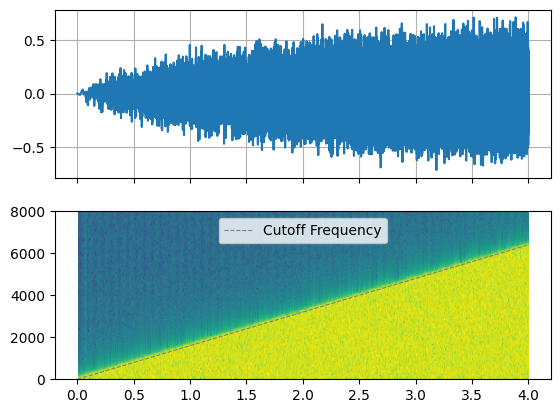

In [8]:
plot_sinc_ir(filtered, f_cutoff, SAMPLE_RATE)

### Oscillating cutoff frequency

By oscillating the cutoff frequency, we can emulate an effect of
Low-frequency oscillation (LFO).




In [9]:
PI2 = torch.pi * 2
num_filters = 90 * duration

f_lfo = torch.linspace(0.9, 0.1, num_filters)
f_cutoff_osci = torch.linspace(0.01, 0.03, num_filters) * torch.sin(torch.cumsum(f_lfo, dim=0))
f_cutoff_base = torch.linspace(0.8, 0.03, num_filters) ** 1.7
f_cutoff = f_cutoff_base + f_cutoff_osci

In [10]:
kernel = sinc_impulse_response(f_cutoff, window_size)
filtered = filter_waveform(noise, kernel)

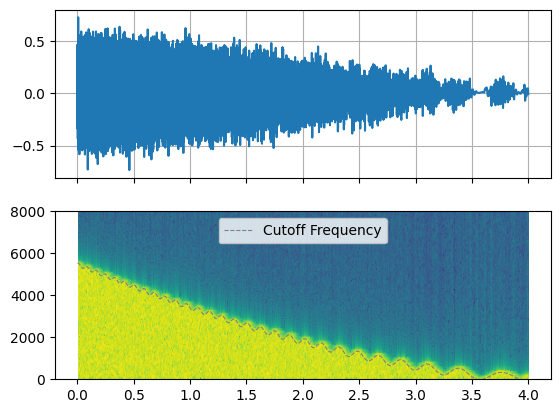

In [11]:
plot_sinc_ir(filtered, f_cutoff, SAMPLE_RATE)

### Wah-wah effects

Wah-wah effects are applications of low-pass filter or band-pass filter.
They change the cut-off freuqnecy or Q-factor quickly.



In [12]:
f_lfo = torch.linspace(0.15, 0.15, num_filters)
f_cutoff = 0.07 + 0.06 * torch.sin(torch.cumsum(f_lfo, dim=0))

In [13]:
kernel = sinc_impulse_response(f_cutoff, window_size)
filtered = filter_waveform(noise, kernel)

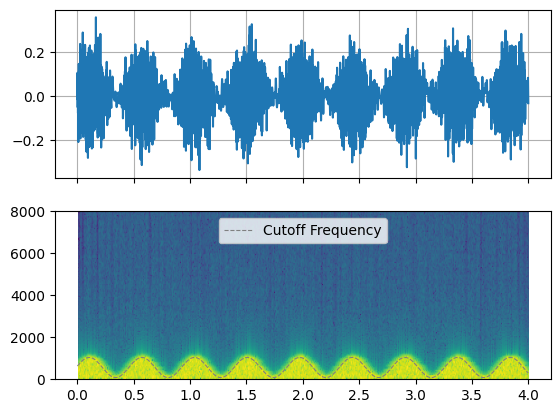

In [14]:
plot_sinc_ir(filtered, f_cutoff, SAMPLE_RATE)

## Arbitrary frequence response

By using
:py:func:`~torchaudio.prototype.functinal.frequency_impulse_response`,
one can directly control the power distribution over frequency.




In [15]:
magnitudes = torch.sin(torch.linspace(0, 10, 64)) ** 4.0
kernel = frequency_impulse_response(magnitudes)
filtered = filter_waveform(noise, kernel.unsqueeze(0))

In [16]:
def plot_waveform(magnitudes, filtered, sample_rate):
    nyquist = sample_rate / 2
    num_samples = filtered.size(-1)
    duration = num_samples / sample_rate

    # Re-organize magnitudes for overlay
    N = 10  # number of overlays
    interval = torch.linspace(0.05, 0.95, N)
    offsets = duration * interval
    # Select N magnitudes for overlays
    mags = torch.stack(
        [magnitudes for _ in range(N)]
        if magnitudes.ndim == 1
        else [magnitudes[int(i * magnitudes.size(0))] for i in interval]
    )
    mag_x = offsets.unsqueeze(-1) + 0.1 * mags
    mag_y = torch.linspace(0, nyquist, magnitudes.size(-1)).tile((N, 1))

    _, ax = plt.subplots(1, 1, sharex=True)
    ax.vlines(offsets, 0, nyquist, color="gray", linestyle="--", linewidth=0.8)
    ax.plot(mag_x.T.numpy(), mag_y.T.numpy(), color="gray", linewidth=0.8)
    ax.specgram(filtered, Fs=sample_rate)
    return Audio(filtered, rate=sample_rate)

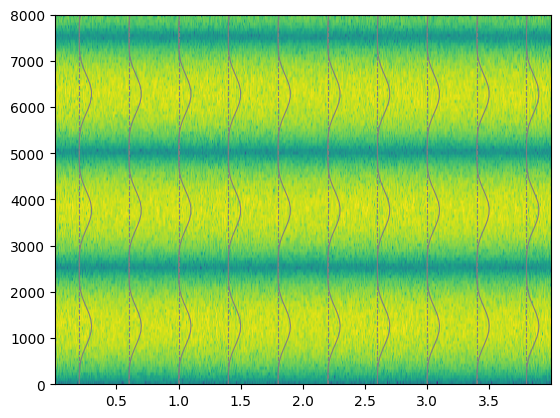

In [17]:
plot_waveform(magnitudes, filtered, SAMPLE_RATE)

It is also possible to make a non-stationary filter.



In [18]:
magnitudes = torch.stack([torch.linspace(0.0, w, 1000) for w in torch.linspace(4.0, 40.0, 250)])
magnitudes = torch.sin(magnitudes) ** 4.0

In [19]:
kernel = frequency_impulse_response(magnitudes)
filtered = filter_waveform(noise, kernel)

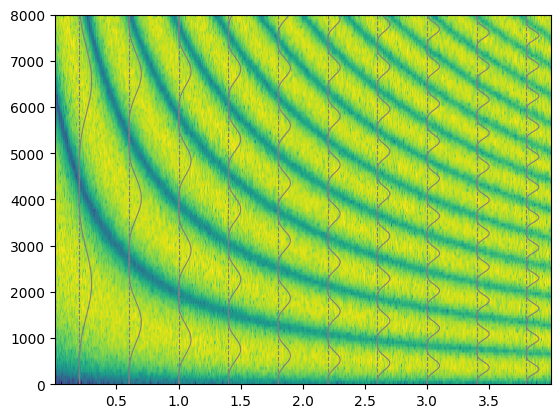

In [20]:
plot_waveform(magnitudes, filtered, SAMPLE_RATE)

Of course it is also possible to emulate simple low pass filter.



In [21]:
magnitudes = torch.concat([torch.ones((32,)), torch.zeros((32,))])

In [22]:
kernel = frequency_impulse_response(magnitudes)
filtered = filter_waveform(noise, kernel.unsqueeze(0))

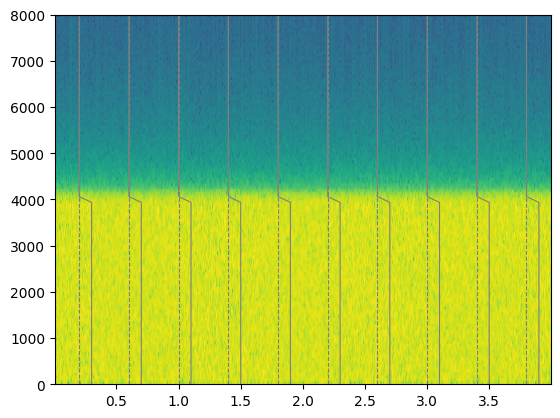

In [23]:
plot_waveform(magnitudes, filtered, SAMPLE_RATE)

## References

- https://en.wikipedia.org/wiki/Additive_synthesis
- https://computermusicresource.com/Simple.bell.tutorial.html
- https://computermusicresource.com/Definitions/additive.synthesis.html

